In [1]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


In [2]:
bn = gum.fastBN("hand_wash{no|yes}->prevention[.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4]<-sanitizer{no|yes};avoid{no|yes}->prevention<-face_cover{no|yes};workspace_cleaning{no|yes}->prevention<-berth_cleaning{no|yes};distance{no|yes}->prevention->has_covid{no|yes};age{18-24|25-29|30-39|40-59}->vulnerability{no|yes}->has_covid->symptoms{0|1-3|4-5|6-8|>8};gender{male|female}->vulnerability;infection_rate[11]->has_covid")
bn

(gum::BayesNet<double>@0x1a5d1ea46e0) BN{nodes: 14, arcs: 13, domainSize: 10^6.52881, dim: 2637}

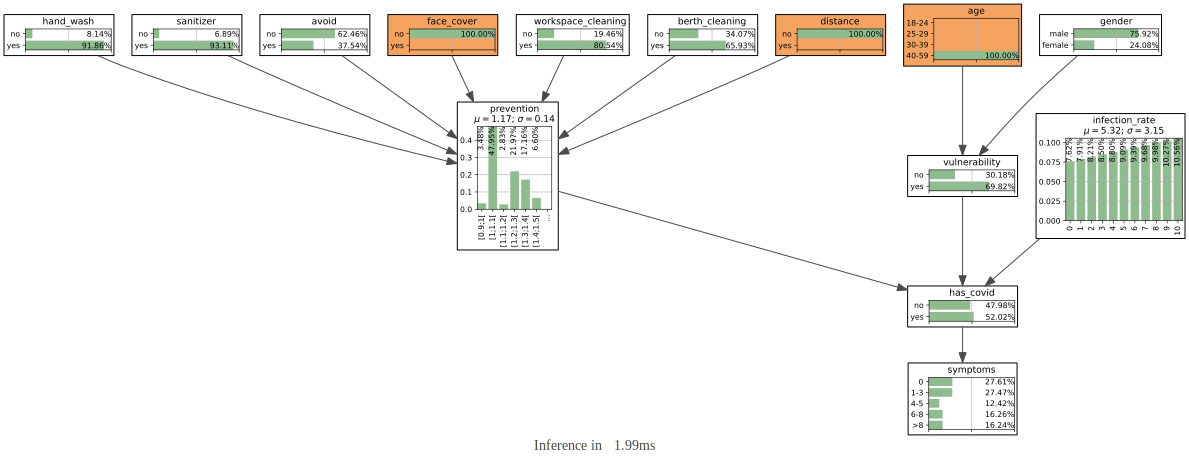

In [5]:
bn.cpt("hand_wash")[:]=[31,351]
bn.cpt("sanitizer")[:]=[26,356]
bn.cpt("avoid")[:]=[237,145]
bn.cpt("face_cover")[:]=[99,283]
bn.cpt("workspace_cleaning")[:]=[75,307]
bn.cpt("berth_cleaning")[:]=[130,252]
bn.cpt("distance")[:]=[190,192]
bn.cpt("age")[:]=[77+36,50+28,87+61,24+19]
bn.cpt("gender")[:]=[190+99,48+45]
#bn.cpt("ELISA_test")[:]=[[144/154, 10/154],[0, 228/228]]
#bn.cpt("previous_RT-PCR_test")[:]=[[131/154, 23/154],[16/228, 212/228]]


bn.cpt("infection_rate").fillWith(1).normalize()

bn.cpt("symptoms")[:]=[[54,49,13,16,12],[44,51,37,50,56]]

gender = np.zeros((2,2))
gender[0]=[.343,.657]
gender[1]=[.484,.516]


age = np.zeros((4,2))
age[0]=[.319,.681]
age[1]=[.359,.641]
age[2]=[.412,.588]
age[3]=[.442,.558]


for i in range(2):
    for j in range(4):
        no_vulnerability = gender[i][0]*age[j][0]
        yes_vulnerability = gender[i][1]*age[j][1]
        sum_vulnerability = no_vulnerability + yes_vulnerability
        bn.cpt("vulnerability")[i,j]=[no_vulnerability/sum_vulnerability,yes_vulnerability/sum_vulnerability]

action = np.zeros((7,2))
action[0]=[218,133]
action[1]=[219,137]
action[2]=[78,67]
action[3]=[158,125]
action[4]=[195,112]
action[5]=[156,96]
action[6]=[105,87]

unaction = action
original_action = np.copy(action)
action = np.transpose(action)
action = action/np.sum(action,0)
action = np.transpose(action)

unaction[:,0] =  238-unaction[:,0]
unaction[:,1] =  144-unaction[:,1]
original_unaction = np.copy(unaction)

unaction = np.transpose(unaction)
unaction = unaction/np.sum(unaction,0)
unaction = np.transpose(unaction)

store = np.zeros((2,7,2))
store[0] = unaction
store[1] = action

original_store = np.zeros((2,7,2))
original_store[0] = original_unaction
original_store[1] = original_action

for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    for n in range(2):
                        for o in range(2):
                            #arr = store[i][0][0] + store[j][1][0] + store[k][2][0] + store[l][3][0] + store[m][4][0] + store[n][5][0] + store[o][6][0]
                            #arr=arr/7.0
                            
                            #arr = original_store[i][0][0] + \
                            #    original_store[j][1][0] + \
                            #    original_store[k][2][0] + \
                            #    original_store[l][3][0] + \
                            #    original_store[m][4][0] + \
                            #    original_store[n][5][0] + \
                            #    original_store[o][6][0]
                            #arr = arr/(arr + original_store[i][0][1] + original_store[j][1][1] + original_store[k][2][1] + original_store[l][3][1] + original_store[m][4][1] + original_store[n][5][1] + original_store[o][6][1])
                            arr = (1+(store[0][0][0]-store[i][0][0])/store[0][0][0]) * \
                                (1+(store[0][1][0]-store[j][1][0])/store[0][1][0]) * \
                                (1+(store[0][2][0]-store[k][2][0])/store[0][2][0]) * \
                                (1+(store[0][3][0]-store[l][3][0])/store[0][3][0]) * \
                                (1+(store[0][4][0]-store[m][4][0])/store[0][4][0]) * \
                                (1+(store[0][5][0]-store[n][5][0])/store[0][5][0]) * \
                                (1+(store[0][6][0]-store[o][6][0])/store[0][6][0])
                            temp = np.zeros((15))
                            arr = np.int((arr-0.9)/0.1)
                            temp[arr]=1
                            bn.cpt('prevention')[o,n,m,l,k,j,i]=temp


for vul in range(2):
    for prev in range(0,15):
        for ir in range(11):
            prevention_index = prev*0.1+0.9+1
            arr = ir/10/prevention_index*(vul+1)
            if arr>1:
                arr = 1
            #arr = ir/10.0*(vul+1)/(prev*0.1+0.9)
            bn.cpt('has_covid')[ir,vul,prev]=[1-arr, arr]
                            
#gnb.showInference(bn,evs={'hand_wash':'yes', 'sanitizer':'yes', 'avoid':'yes', 'face_cover':'yes', 'workspace_cleaning':'yes', 'berth_cleaning':'yes', 'distance':'yes'},size="100")   

gnb.showInference(bn,evs={'face_cover':'no', 'distance':'no', 'age':'40-59'},size="25") 


0.9


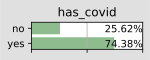

1.0


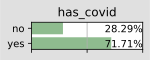

1.5


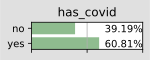

2.0


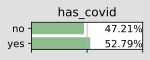

2.3


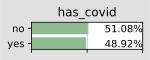

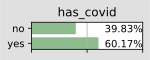

In [60]:
ie=gum.LazyPropagation(bn)
test_case = ['0.9','1.0','1.5','2.0','2.3']
for i in range(len(test_case)):
    print(test_case[i])
    ie.setEvidence({'infection_rate':7,'prevention':test_case[i]})
    ie.makeInference()
    gnb.showProba(ie.posterior('has_covid'))
ie.setEvidence({'infection_rate':7})
ie.makeInference()
gnb.showProba(ie.posterior('has_covid'))

In [4]:
bn.cpt('prevention')

(gum::Potential<double>@0x2a77230f580) <prevention:[0.9;1[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 1 /<prevention:[1;1.1[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.1;1.2[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.2;1.3[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.3;1.4[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.4;1.5[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.5;1.6[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.6;1.7[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.7;1.8[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.8;1.9[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.9;2[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2;2.1[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.1;2.2[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.2;2.3[|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.3;2.4]|hand_wash:no|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[0.9;1[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1;1.1[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 1 /<prevention:[1.1;1.2[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.2;1.3[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.3;1.4[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.4;1.5[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.5;1.6[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.6;1.7[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.7;1.8[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.8;1.9[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[1.9;2[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2;2.1[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.1;2.2[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.2;2.3[|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[2.3;2.4]|hand_wash:yes|sanitizer:no|avoid:no|face_cover:no|workspace_cleaning:no|berth_cleaning:no|distance:no> :: 0 /<prevention:[0.9;1[|hand_wash:no|sanitizer:yes|avoid:no|face_c

0


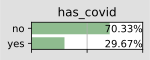

1-3


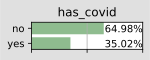

4-5


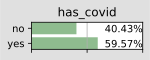

6-8


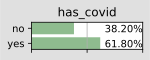

>8


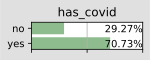

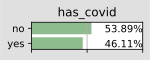

In [41]:
ie=gum.LazyPropagation(bn)
test_case = ['0','1-3','4-5','6-8','>8']
for i in range(len(test_case)):
    print(test_case[i])
    ie.setEvidence({'symptoms':test_case[i]})
    ie.makeInference()
    gnb.showProba(ie.posterior('has_covid'))
ie.setEvidence({})
ie.makeInference()
gnb.showProba(ie.posterior('has_covid'))

yes


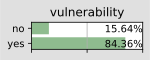

no


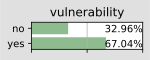

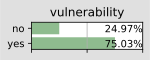

In [44]:
ie=gum.LazyPropagation(bn)
test_case = ['yes','no']
for i in range(len(test_case)):
    print(test_case[i])
    ie.setEvidence({'has_covid':test_case[i]})
    ie.makeInference()
    gnb.showProba(ie.posterior('vulnerability'))
ie.setEvidence({})
ie.makeInference()
gnb.showProba(ie.posterior('vulnerability'))    

0


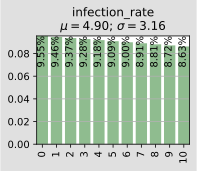

1-3


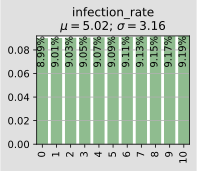

4-5


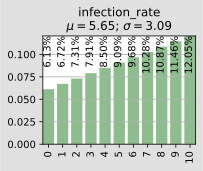

6-8


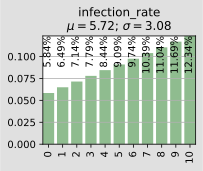

>8


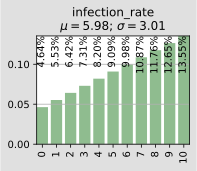

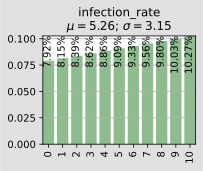

In [7]:
ie=gum.LazyPropagation(bn)
test_case = ['0','1-3','4-5','6-8','>8']
for i in range(len(test_case)):
    print(test_case[i])
    ie.setEvidence({'symptoms':i,'prevention':'2.3'})
    ie.makeInference()
    gnb.showProba(ie.posterior('infection_rate'))
ie.setEvidence({'prevention':'2.3'})
ie.makeInference()
gnb.showProba(ie.posterior('infection_rate'))

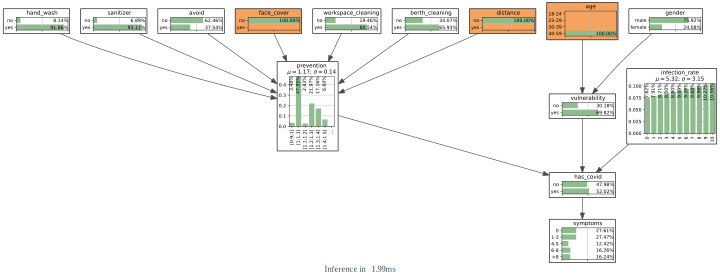

In [13]:
gnb.showInference(bn,evs={'face_cover':'no', 'distance':'no','age':'40-59'},size="10")
